In [1]:
# ============================== IMPORTS ==============================
import os, re, math, random, json, cv2
import numpy as np
import tensorflow as tf 
from collections import defaultdict
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
from PIL import Image
from glob import glob
from tqdm import tqdm
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import tensorflow.keras.backend as K
from tensorflow.keras import mixed_precision

# Enable mixed precision globally
mixed_precision.set_global_policy('mixed_float16')

# ============================== CONFIG ==============================
DATA_DIR = "data"
IMG_SIZE = 256
NUM_CLASSES = 4
SEED = 42
EPOCHS = 30
BATCH_SIZE = 1
SEQ_LEN = 10
SLIDE_STRIDE = 10
SEQS_PER_VIDEO = 100

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070, compute capability 8.6


In [2]:
# The model
def _get_group_norm():
    try:
        from tensorflow_addons.layers import GroupNormalization
        return GroupNormalization
    except Exception:
        return None

GN = _get_group_norm()

def conv_norm_act_drop(x, filters, name_prefix, dropout_rate=0.25, groups=8):
    x = layers.TimeDistributed(
        layers.Conv2D(filters, (3, 3), padding='same',
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(1e-5)),
        name=f"{name_prefix}_conv")(x)

    # --- FIX: apply normalization directly on 5D, not via TimeDistributed ---
    if GN is not None:
        # Normalize over channels (groups) for each (B,T,H,W, C)
        x = GN(groups=groups, axis=-1, name=f"{name_prefix}_gn", dtype='float32')(x)
    else:
        x = layers.LayerNormalization(axis=[2,3,4], name=f"{name_prefix}_ln", dtype='float32')(x)

    # Activation can operate on 5D directly
    x = layers.Activation('elu', name=f"{name_prefix}_act")(x)

    # Spatial dropout still needs per-frame application
    x = layers.TimeDistributed(
        layers.SpatialDropout2D(dropout_rate),
        name=f"{name_prefix}_sdrop"
    )(x)
    return x

# ======================================
# Optional: Timewise Squeeze-Excitation
# ======================================
def time_se(x, r=8, name="tse"):
    """Channel attention per frame (very light)."""
    c = x.shape[-1]
    s = layers.TimeDistributed(layers.GlobalAveragePooling2D(), name=f"{name}_gap")(x)  # (B,T,C)
    s = layers.TimeDistributed(layers.Dense(max(c // r, 1), activation='relu'), name=f"{name}_fc1")(s)
    s = layers.TimeDistributed(layers.Dense(c, activation='sigmoid'), name=f"{name}_fc2")(s)
    s = layers.TimeDistributed(layers.Reshape((1, 1, c)))(s)
    return layers.Multiply(name=f"{name}_scale")([x, s])

# =====================================
# Gradient checkpointing (recompute)
# =====================================
def _maybe_recompute(fn):
    """Wrap a function with tfa.utils.recompute_grad if available; else identity."""
    try:
        import tensorflow_addons as tfa
        return tfa.utils.recompute_grad(fn)
    except Exception:
        return fn  # no-op

def bclstm_block(x, filters, name_prefix, use_recompute=False, time_se_on=True, bidir=False):
    def core(inp):
        if bidir:
            y = layers.Bidirectional(
                layers.ConvLSTM2D(filters=filters // 2, kernel_size=(3,3),
                                  padding='same', return_sequences=True),
                name=f"{name_prefix}_bclstm")(inp)
        else:
            y = layers.ConvLSTM2D(filters=filters, kernel_size=(3,3),
                                  padding='same', return_sequences=True,
                                  name=f"{name_prefix}_clstm")(inp)
        if time_se_on:
            y = time_se(y, r=8, name=f"{name_prefix}_tse")
        return y
    return _maybe_recompute(core)(x) if use_recompute else core(x)


# ===================================
# UpSampling+Conv (no checkerboards)
# ===================================
def upsample_concat(x, skip, filters, name_prefix):
    x = layers.TimeDistributed(
        layers.UpSampling2D((2, 2), interpolation='bilinear'),
        name=f"{name_prefix}_upsample")(x)
    x = layers.TimeDistributed(
        layers.Conv2D(filters, (1, 1), padding='same',
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(1e-5)),
        name=f"{name_prefix}_proj")(x)
    return layers.Concatenate(name=f"{name_prefix}_concat")([x, skip])


# ==========================
# Deep supervision head(s)
# ==========================
def aux_head_upsampled(x, num_classes, name, target_size=256):
    """1x1 conv -> softmax -> upsample to 256x256 per time step."""
    # aux_head_upsampled:
    x = layers.TimeDistributed(layers.Conv2D(
            num_classes, (1, 1), padding='same',
            kernel_initializer='he_normal',
            kernel_regularizer=regularizers.l2(1e-5)),
        name=f"{name}_logits")(x)
    
    x = layers.TimeDistributed(layers.Activation('softmax', dtype='float32'),
                           name=f"{name}_softmax")(x)
    # Upsample to 256 if needed
    h = x.shape[2]
    if h is not None and h != target_size:
        scale = target_size // int(h)
        x = layers.TimeDistributed(
                layers.UpSampling2D(size=(scale, scale), interpolation='bilinear'),
                name=f"{name}_up")(x)
    return x


# ==========================
# Model builder (U-LSTM5^CE)
# ==========================
def build_ULSTM5_CE_DS(input_shape=(SEQ_LEN, 256, 256, 3),
                       num_classes=4,
                       enc_dec_dropout=0.25,
                       bottleneck_dropout=0.35,
                       groups=8,
                       add_time_se=True,
                       use_recompute_on_deep=True):
    """
    U-LSTM5 with:
      - GroupNorm (LN fallback), ELU, SpatialDropout2D
      - UpSampling+Conv in decoder
      - Deep supervision at dec2 & dec3
      - Optional Time-SE after each B-ConvLSTM
      - Gradient checkpointing on enc4/enc5/dec4 ConvLSTM blocks
    """
    inputs = layers.Input(shape=input_shape, name='input_seq')
    x = inputs

    # Encoder
    skips = []
    filter_sizes = [32, 64, 128, 192, 256]

    for i, f in enumerate(filter_sizes):
        dr = bottleneck_dropout if i == len(filter_sizes) - 1 else enc_dec_dropout
        x = conv_norm_act_drop(x, f, f"enc{i+1}_a", dropout_rate=dr, groups=groups)
        x = conv_norm_act_drop(x, f, f"enc{i+1}_b", dropout_rate=dr, groups=groups)

        # Recompute only on the deeper (VRAM-heavy) ConvLSTMs
        need_recompute = use_recompute_on_deep and (i >= 3)  # enc4, enc5
        x = bclstm_block(x, f, name_prefix=f"enc{i+1}",
                         use_recompute=need_recompute,
                         time_se_on=add_time_se,
                         bidir=False)
        skips.append(x)
        if i < len(filter_sizes) - 1:
            x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)),
                                       name=f"enc{i+1}_pool")(x)

    
    # Decoder with deep supervision taps
    dec_outputs = {}
    for i in reversed(range(len(filter_sizes) - 1)):
        f = filter_sizes[i]
        x = upsample_concat(x, skips[i], f, name_prefix=f"dec{i+1}")
        x = conv_norm_act_drop(x, f, f"dec{i+1}_a", dropout_rate=enc_dec_dropout, groups=groups)
        x = conv_norm_act_drop(x, f, f"dec{i+1}_b", dropout_rate=enc_dec_dropout, groups=groups)

        # Recompute only the first (deepest) decoder BCLSTM
        need_recompute = use_recompute_on_deep and (i == len(filter_sizes) - 2)  # dec4
        x = bclstm_block(x, f, name_prefix=f"dec{i+1}",
                         use_recompute=need_recompute,
                         time_se_on=add_time_se,
                         bidir=False)

        # Collect deep supervision at dec2 (128) and dec3 (64)
        if i == 2:   # dec3 output is 64x64
            dec_outputs['aux3'] = x
        if i == 1:   # dec2 output is 128x128
            dec_outputs['aux2'] = x

    # Heads
    # main head:
    main_logits = layers.TimeDistributed(
        layers.Conv2D(num_classes, (1, 1), padding='same',
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(1e-5)),
        name='main_logits')(x)

    main = layers.TimeDistributed(layers.Activation('softmax', dtype='float32'),
                              name='main')(main_logits)

    aux2 = aux_head_upsampled(dec_outputs['aux2'], num_classes, name='aux2')  # 128 -> 256
    aux3 = aux_head_upsampled(dec_outputs['aux3'], num_classes, name='aux3')  # 64  -> 256

    model = models.Model(inputs=inputs, outputs=[main, aux2, aux3], name='U_LSTM5_CE_DS')
    return model

#  ==========================
#  Losses and compile helper
#  ==========================
def dice_per_class(y_true, y_pred, smooth=1e-6):
    # y_true/y_pred: (B,T,H,W,C)
    axes = [1,2,3]  # sum over T,H,W
    intersection = tf.reduce_sum(y_true * y_pred, axis=axes)
    denom = tf.reduce_sum(y_true + y_pred, axis=axes)
    dice = (2. * intersection + smooth) / (denom + smooth)  # (B,C)
    return dice

def dice_loss_weighted(y_true, y_pred, class_weights=None):
    if class_weights is None:
        class_weights = tf.ones([tf.shape(y_pred)[-1]], dtype=y_pred.dtype)
    dpc = dice_per_class(y_true, y_pred)  # (B,C)
    dpc = tf.reduce_mean(dpc, axis=0)     # mean over batch -> (C,)
    return 1.0 - tf.reduce_sum(dpc * class_weights) / tf.reduce_sum(class_weights)

def ce_dice_hybrid(class_weights=(0.05, 0.35, 0.30, 0.30), alpha_ce=0.0, alpha_dice=1.0):
    # Combined categorical cross-entropy + weighted Dice.
    def loss(y_true, y_pred):
        ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.05)
        ce = tf.reduce_mean(ce)
        dl = dice_loss_weighted(y_true, y_pred, class_weights=class_weights)
        return alpha_ce * ce + alpha_dice * dl
    return loss

lf = ce_dice_hybrid
# ==========================
# Example usage
# ==========================
model = build_ULSTM5_CE_DS(input_shape=(SEQ_LEN, 256, 256, 3),
                           num_classes=4,
                           enc_dec_dropout=0.25,
                           bottleneck_dropout=0.35,
                           add_time_se=True,
                           use_recompute_on_deep=True)

# model.summary()

In [3]:
model.load_weights("WEIGHTS/U-LSTM5^CE_DS-Weighted_Dice_12.11.2025/top3_swa.h5")

In [4]:
import os, re, math
from glob import glob
import numpy as np
from PIL import Image
import tensorflow as tf
from tqdm import tqdm

# -------- utilities you already had ----------
def dice_score(gt, pred, class_idx):
    gt_bin = (gt == class_idx).astype(np.uint8)
    pred_bin = (pred == class_idx).astype(np.uint8)
    intersection = np.sum(gt_bin * pred_bin)
    return (2. * intersection + 1e-6) / (np.sum(gt_bin) + np.sum(pred_bin) + 1e-6)

# -------- helpers (image I/O) ----------
def _load_rgb_and_glottis_pair(folder, idx):
    """
    Load N.png (RGB or gray) and N_seg.png (binary glottis) from a croped_256 folder.
    Returns: img_float (256,256,3) in [0,1], glottis_bin (256,256) uint8 {0,1}
    """
    ip = os.path.join(folder, f"{idx}.png")
    sp = os.path.join(folder, f"{idx}_seg.png")
    if not (os.path.exists(ip) and os.path.exists(sp)):
        return None, None

    pil = Image.open(ip)
    if pil.mode == "L":
        im = np.array(pil, dtype=np.uint8)
        im = np.stack([im, im, im], axis=-1)
    else:
        im = np.array(pil.convert("RGB"), dtype=np.uint8)
    img = (im.astype(np.float32) / 255.0)

    seg = Image.open(sp).convert("L")
    glo = (np.array(seg) > 0).astype(np.uint8)

    # ensure size 256x256
    if img.shape[:2] != (256, 256):
        img = tf.image.resize(img, (256, 256), method="bilinear").numpy().astype(np.float32)
    if glo.shape != (256, 256):
        glo = tf.image.resize(glo[..., None], (256, 256), method="nearest").numpy().astype(np.uint8)[..., 0]

    return img, glo

def _numeric_sort_key(p):
    """Sort '15.png' before '100.png' by extracting the leading integer stem."""
    m = re.match(r"^(\d+)$", p) or re.match(r"^(\d+)\.png$", p)
    return int(m.group(1)) if m else p

# -------- main processing for one video ----------
def _process_one_video(model, crop_dir, seq_len=10, sliding_stride=10, overwrite=False):
    """
    For a single .../<VIDEO>/croped_256 directory:
      - build 10-frame sequences
      - predict probabilities, average across overlaps
      - compute Dice on raw predictions (class=1)
      - fuse GT glottis into the prediction
      - save N_seg4.png
      - write avg Dice1 to TXT and return it
    """
    # collect available indices that have BOTH image and _seg
    pngs = [os.path.basename(p) for p in glob(os.path.join(crop_dir, "*.png"))]
    stems = set([s.replace(".png", "") for s in pngs])
    idxs = sorted([s for s in stems if s.isdigit() and f"{s}_seg" in stems], key=_numeric_sort_key)
    if len(idxs) < seq_len:
        return None  # not enough frames, skip

    # Preload all frames for this video
    imgs = []
    gt_glottis = []
    keep_names = []
    for s in idxs:
        im, glo = _load_rgb_and_glottis_pair(crop_dir, s)
        if im is None:
            continue
        imgs.append(im)
        gt_glottis.append(glo)
        keep_names.append(s)
    if len(imgs) < seq_len:
        return None

    N = len(imgs)
    H, W = 256, 256
    C = 4

    # Accumulators for soft probabilities (average across overlapping sequences)
    prob_acc = np.zeros((N, H, W, C), dtype=np.float32)
    prob_cnt = np.zeros((N,), dtype=np.int32)

    # Build sliding windows over indices [0..N-1]
    windows = [(i, i+seq_len) for i in range(0, N - seq_len + 1, sliding_stride)]
    for start, end in tqdm(windows, desc=f"Infer {os.path.basename(os.path.dirname(crop_dir))}", leave=False):
        x_seq = np.stack(imgs[start:end], axis=0)             # (T,256,256,3)
        x_seq = x_seq[None, ...]                              # (B=1,T,H,W,C)

        y_all = model.predict(x_seq, verbose=0)
        y_main = y_all[0] if isinstance(y_all, (list, tuple)) else y_all   # (1,T,H,W,4)
        if y_main.ndim != 5:
            raise ValueError(f"Expected (B,T,H,W,C) from model, got {y_main.shape}")

        probs = y_main[0]  # (T,H,W,4)
        # if the head emits logits (not probabilities), apply softmax
        if not np.allclose(np.sum(probs[0], axis=-1).mean(), 1.0, atol=1e-3):
            probs = tf.nn.softmax(probs, axis=-1).numpy()

        for t in range(probs.shape[0]):
            prob_acc[start + t] += probs[t]
            prob_cnt[start + t] += 1

    # Produce per-frame predictions and outputs
    dices = []
    out_txt_lines = []
    for k, stem in enumerate(keep_names):
        # average probs -> argmax labels
        denom = max(1, int(prob_cnt[k]))
        prob_k = prob_acc[k] / float(denom)
        pred_labels = np.argmax(prob_k, axis=-1).astype(np.uint8)  # (256,256)

        # Dice on raw prediction (before fusion), class 1
        gt_labelmap = (gt_glottis[k].astype(np.uint8))  # 0/1, where 1=glottis
        # Convert GT to a multi-class labelmap with only classes {0,1}
        dice1 = dice_score(gt_labelmap, pred_labels, class_idx=1)
        dices.append(dice1)
        out_txt_lines.append(f"{stem}: DICE1={dice1:.4f}")

        # Replace model's glottis with GT glottis
        fused = pred_labels.copy()
        fused[pred_labels == 1] = 0                 # clear any predicted glottis
        fused[gt_glottis[k] == 1] = 1               # write GT glottis back in

        # Save N_seg4.png (uint8 labels 0..3)
        out_path = os.path.join(crop_dir, f"{stem}_seg4.png")
        if overwrite or (not os.path.exists(out_path)):
            Image.fromarray(fused, mode="L").save(out_path)

    avg_dice = float(np.mean(dices)) if len(dices) else 0.0

    # Write summary TXT in the croped_256 folder
    with open(os.path.join(crop_dir, "avg_dice_glottis.txt"), "w", encoding="utf-8") as f:
        f.write(f"AVG_DICE1 {avg_dice:.4f}\n")
        for line in out_txt_lines:
            f.write(line + "\n")

    return avg_dice

# -------- driver over the full organized root ----------
def process_bagls_organized_sequences(model,
                                      root_dir,
                                      seq_len=SEQ_LEN,
                                      sliding_stride=SLIDE_STRIDE,
                                      overwrite=False):
    """
    Walks every immediate subfolder of `root_dir`, finds '<video>/croped_256',
    runs inference + fusion as described, writes per-video TXT, and prints a
    descending list of averages.

    Returns: list of tuples [(video_name, avg_dice1), ...] sorted descending.
    """
    assert os.path.isdir(root_dir), f"Not a directory: {root_dir}"

    results = []
    subfolders = sorted([p for p in glob(os.path.join(root_dir, "*")) if os.path.isdir(p)])
    for vid_dir in subfolders:
        crop_dir = os.path.join(vid_dir, "croped_256")
        if not os.path.isdir(crop_dir):
            continue
        avg = _process_one_video(model, crop_dir, seq_len=seq_len,
                                 sliding_stride=sliding_stride, overwrite=overwrite)
        if avg is None:
            continue
        video_name = os.path.basename(vid_dir)
        results.append((video_name, avg))

    # sort and print
    results.sort(key=lambda x: x[1], reverse=True)
    print("\n=== AVG Glottis Dice per Video (descending) ===")
    for name, avg in results:
        print(f"{name}: AVG DICE1 = {avg:.4f}")
    return results

In [ ]:
# Iterative results - DO NOT RE-RUN OR REPLACE! CREATE EXTRA CELLS!
# Below are the full results for all iterations of BAGLS segmentation with AVG dice coef. per sequence.

In [6]:
# First Iteration (train set):
list_of_dices = process_bagls_organized_sequences(model, r"D:\bagls-data\BAGLS\training\organized")


=== AVG Glottis Dice per Video (descending) ===
512x256 - 492: AVG DICE1 = 0.9460
512x256 - 400: AVG DICE1 = 0.9392
512x256 - 229: AVG DICE1 = 0.9371
512x256 - 16: AVG DICE1 = 0.9363
512x256 - 565: AVG DICE1 = 0.9344
512x256 - 275: AVG DICE1 = 0.9282
512x256 - 332: AVG DICE1 = 0.9266
512x256 - 125: AVG DICE1 = 0.9258
512x256 - 179: AVG DICE1 = 0.9242
512x256 - 612: AVG DICE1 = 0.9239
512x256 - 533: AVG DICE1 = 0.9236
512x256 - 174: AVG DICE1 = 0.9230
512x256 - 96: AVG DICE1 = 0.9229
512x256 - 171: AVG DICE1 = 0.9219
512x256 - 465: AVG DICE1 = 0.9191
512x256 - 448: AVG DICE1 = 0.9187
512x256 - 212: AVG DICE1 = 0.9185
512x256 - 49: AVG DICE1 = 0.9184
512x256 - 616: AVG DICE1 = 0.9178
512x256 - 540: AVG DICE1 = 0.9175
512x256 - 243: AVG DICE1 = 0.9153
512x256 - 462: AVG DICE1 = 0.9148
512x256 - 276: AVG DICE1 = 0.9139
512x256 - 265: AVG DICE1 = 0.9136
512x256 - 391: AVG DICE1 = 0.9136
512x256 - 0: AVG DICE1 = 0.9134
512x256 - 459: AVG DICE1 = 0.9120
512x256 - 486: AVG DICE1 = 0.9107
512x

In [11]:
# 2nd Iteration (train set):
list_of_dices = process_bagls_organized_sequences(model, r"D:\bagls-data\BAGLS\training\organized")


=== AVG Glottis Dice per Video (descending) ===
512x256 - 493: AVG DICE1 = 0.9861
512x256 - 457: AVG DICE1 = 0.9772
512x256 - 127: AVG DICE1 = 0.9772
512x256 - 531: AVG DICE1 = 0.9748
512x256 - 572: AVG DICE1 = 0.9739
512x256 - 454: AVG DICE1 = 0.9724
512x256 - 502: AVG DICE1 = 0.9716
512x256 - 74: AVG DICE1 = 0.9694
512x256 - 142: AVG DICE1 = 0.9682
512x256 - 585: AVG DICE1 = 0.9667
512x256 - 289: AVG DICE1 = 0.9663
512x256 - 451: AVG DICE1 = 0.9654
512x256 - 20: AVG DICE1 = 0.9638
512x256 - 183: AVG DICE1 = 0.9628
512x256 - 157: AVG DICE1 = 0.9614
512x256 - 511: AVG DICE1 = 0.9614
512x256 - 510: AVG DICE1 = 0.9613
512x256 - 372: AVG DICE1 = 0.9611
512x256 - 379: AVG DICE1 = 0.9611
512x256 - 360: AVG DICE1 = 0.9606
512x256 - 105: AVG DICE1 = 0.9602
512x256 - 630: AVG DICE1 = 0.9599
512x256 - 434: AVG DICE1 = 0.9589
512x256 - 354: AVG DICE1 = 0.9584
512x256 - 310: AVG DICE1 = 0.9583
512x256 - 458: AVG DICE1 = 0.9572
512x256 - 232: AVG DICE1 = 0.9522
512x256 - 596: AVG DICE1 = 0.9521
5

In [5]:
# BAGLS Test Set Iteration:
list_of_dices = process_bagls_organized_sequences(model, r"D:\bagls-data\BAGLS\test_organized")


=== AVG Glottis Dice per Video (descending) ===
352x208 - 366: AVG DICE1 = 0.9603
512x128 - 617: AVG DICE1 = 0.9186
512x256 - 84: AVG DICE1 = 0.9155
512x256 - 442: AVG DICE1 = 0.9155
512x256 - 151: AVG DICE1 = 0.9137
512x256 - 135: AVG DICE1 = 0.9090
352x208 - 267: AVG DICE1 = 0.9020
320x256 - 263: AVG DICE1 = 0.9015
512x128 - 60: AVG DICE1 = 0.8942
512x256 - 452: AVG DICE1 = 0.8853
512x256 - 508: AVG DICE1 = 0.8802
352x256 - 213: AVG DICE1 = 0.8784
256x256 - 259: AVG DICE1 = 0.8732
512x256 - 517: AVG DICE1 = 0.8691
320x256 - 566: AVG DICE1 = 0.8670
256x256 - 70: AVG DICE1 = 0.8476
352x208 - 89: AVG DICE1 = 0.8465
512x256 - 147: AVG DICE1 = 0.8441
320x256 - 358: AVG DICE1 = 0.8412
352x208 - 384: AVG DICE1 = 0.8330
256x256 - 525: AVG DICE1 = 0.8290
256x256 - 392: AVG DICE1 = 0.8266
512x256 - 323: AVG DICE1 = 0.8246
256x256 - 27: AVG DICE1 = 0.8066
352x256 - 46: AVG DICE1 = 0.8008
256x256 - 467: AVG DICE1 = 0.7935
320x256 - 547: AVG DICE1 = 0.7757
256x120 - 108: AVG DICE1 = 0.7715
256x2

In [7]:
# 3rd Iteration (train set):
list_of_dices = process_bagls_organized_sequences(model, r"D:\bagls-data\BAGLS\training\organized")


=== AVG Glottis Dice per Video (descending) ===
256x256 - 353: AVG DICE1 = 0.9432
320x256 - 188: AVG DICE1 = 0.9332
256x256 - 152: AVG DICE1 = 0.9242
320x256 - 575: AVG DICE1 = 0.9227
352x208 - 573: AVG DICE1 = 0.9186
352x208 - 145: AVG DICE1 = 0.9183
512x256 - 6: AVG DICE1 = 0.9125
320x256 - 592: AVG DICE1 = 0.9118
352x208 - 253: AVG DICE1 = 0.9083
256x256 - 613: AVG DICE1 = 0.9077
512x128 - 482: AVG DICE1 = 0.9063
256x256 - 139: AVG DICE1 = 0.9043
512x256 - 498: AVG DICE1 = 0.8997
256x256 - 238: AVG DICE1 = 0.8993
512x256 - 53: AVG DICE1 = 0.8983
288x128 - 415: AVG DICE1 = 0.8977
352x208 - 432: AVG DICE1 = 0.8977
256x256 - 85: AVG DICE1 = 0.8973
256x256 - 529: AVG DICE1 = 0.8968
512x256 - 227: AVG DICE1 = 0.8963
256x256 - 385: AVG DICE1 = 0.8959
256x256 - 380: AVG DICE1 = 0.8956
512x256 - 371: AVG DICE1 = 0.8954
512x256 - 487: AVG DICE1 = 0.8951
512x256 - 356: AVG DICE1 = 0.8944
512x128 - 304: AVG DICE1 = 0.8928
512x256 - 61: AVG DICE1 = 0.8912
512x256 - 472: AVG DICE1 = 0.8874
256x

In [9]:
def copy_top_n_from_sorted(root_dir, target_dir, sorted_dice_list, top_n, cnt_start):
    """
    The function is used to select the best segmentation results for thorough review / manual correction and following Fehling dataset extension.
    
    Take the first `top_n` video folders from `sorted_dice_list` ([(video_name, avg), ...]),
    copy ALL available frame pairs `x.png` + `x_seg4.png` from their `croped_256` subfolders
    into `target_dir`, preserving per-video frame order, while renaming sequentially:

        10001_rgb.png, 10001_mask.png, 10002_rgb.png, 10002_mask.png, ...

    Notes
    -----
    - The global counter starts at 10001 and increases across videos.
    - Only frames that have BOTH files (x.png AND x_seg4.png) are copied.
    - Frame order inside each video is numeric (1.png, 2.png, ...).
    - If a destination filename already exists, the function skips that index
      and moves on to the next number (keeps going, no overwrite).
    """
    import os, re, shutil

    def ensure_dir(p):
        os.makedirs(p, exist_ok=True)

    def numeric_stems_with_pairs(crop_dir):
        """Return sorted integer stems that have both x.png and x_seg4.png."""
        stems = []
        for name in os.listdir(crop_dir):
            if not name.lower().endswith(".png"):
                continue
            m = re.fullmatch(r"(\d+)\.png", name)
            if not m:
                continue
            stem = m.group(1)
            if os.path.exists(os.path.join(crop_dir, f"{stem}_seg4.png")):
                stems.append(int(stem))
        stems.sort()
        return stems

    ensure_dir(target_dir)
    counter = cnt_start
    moved_summary = []

    pick = sorted_dice_list[:top_n] if top_n is not None else sorted_dice_list
    for video_name, _avg in pick:
        crop_dir = os.path.join(root_dir, video_name, "croped_256")
        if not os.path.isdir(crop_dir):
            print(f"⚠️  Missing folder: {crop_dir} — skipped")
            continue

        stems = numeric_stems_with_pairs(crop_dir)
        if not stems:
            print(f"⚠️  No frame pairs in {crop_dir} — skipped")
            continue

        start_here = counter
        moved_here = 0

        for s in stems:
            src_img = os.path.join(crop_dir, f"{s}.png")
            src_msk = os.path.join(crop_dir, f"{s}_seg4.png")

            # find next unused destination index
            while True:
                dst_img = os.path.join(target_dir, f"{counter:05d}_rgb.png")
                dst_msk = os.path.join(target_dir, f"{counter:05d}_mask.png")
                if not (os.path.exists(dst_img) or os.path.exists(dst_msk)):
                    break
                counter += 1  # avoid collision

            try:
                shutil.copy2(src_img, dst_img)
                shutil.copy2(src_msk, dst_msk)
                moved_here += 1
                counter += 1
            except Exception as e:
                print(f"❌ Copy failed for {src_img} / {src_msk}: {e}")

        end_here = counter - 1
        moved_summary.append((video_name, moved_here, start_here, end_here))
        print(f"✅ {video_name}: copied {moved_here} pairs → [{start_here:05d}..{end_here:05d}]")

    total = sum(m for _, m, _, _ in moved_summary)
    print(f"\n📦 Done. Total copied pairs: {total}")
    return moved_summary

In [8]:
# 1st iteration
moved_summary = copy_top_n_from_sorted(r"D:\bagls-data\BAGLS\training\organized", 
                       r"C:\Users\olegp\miniconda3\envs\proj1\0_jupyter_notebook\data\train_extension", 
                       list_of_dices, 100)

✅ 512x256 - 492: copied 100 pairs → [10001..10100]
✅ 512x256 - 400: copied 100 pairs → [10101..10200]
✅ 512x256 - 229: copied 100 pairs → [10201..10300]
✅ 512x256 - 16: copied 100 pairs → [10301..10400]
✅ 512x256 - 565: copied 100 pairs → [10401..10500]
✅ 512x256 - 275: copied 100 pairs → [10501..10600]
✅ 512x256 - 332: copied 100 pairs → [10601..10700]
✅ 512x256 - 125: copied 100 pairs → [10701..10800]
✅ 512x256 - 179: copied 100 pairs → [10801..10900]
✅ 512x256 - 612: copied 100 pairs → [10901..11000]
✅ 512x256 - 533: copied 100 pairs → [11001..11100]
✅ 512x256 - 174: copied 100 pairs → [11101..11200]
✅ 512x256 - 96: copied 100 pairs → [11201..11300]
✅ 512x256 - 171: copied 100 pairs → [11301..11400]
✅ 512x256 - 465: copied 100 pairs → [11401..11500]
✅ 512x256 - 448: copied 100 pairs → [11501..11600]
✅ 512x256 - 212: copied 100 pairs → [11601..11700]
✅ 512x256 - 49: copied 100 pairs → [11701..11800]
✅ 512x256 - 616: copied 100 pairs → [11801..11900]
✅ 512x256 - 540: copied 100 pairs 

In [9]:
for i in moved_summary:
    print(i)

('512x256 - 492', 100, 10001, 10100)
('512x256 - 400', 100, 10101, 10200)
('512x256 - 229', 100, 10201, 10300)
('512x256 - 16', 100, 10301, 10400)
('512x256 - 565', 100, 10401, 10500)
('512x256 - 275', 100, 10501, 10600)
('512x256 - 332', 100, 10601, 10700)
('512x256 - 125', 100, 10701, 10800)
('512x256 - 179', 100, 10801, 10900)
('512x256 - 612', 100, 10901, 11000)
('512x256 - 533', 100, 11001, 11100)
('512x256 - 174', 100, 11101, 11200)
('512x256 - 96', 100, 11201, 11300)
('512x256 - 171', 100, 11301, 11400)
('512x256 - 465', 100, 11401, 11500)
('512x256 - 448', 100, 11501, 11600)
('512x256 - 212', 100, 11601, 11700)
('512x256 - 49', 100, 11701, 11800)
('512x256 - 616', 100, 11801, 11900)
('512x256 - 540', 100, 11901, 12000)
('512x256 - 243', 100, 12001, 12100)
('512x256 - 462', 100, 12101, 12200)
('512x256 - 276', 100, 12201, 12300)
('512x256 - 265', 100, 12301, 12400)
('512x256 - 391', 100, 12401, 12500)
('512x256 - 0', 100, 12501, 12600)
('512x256 - 459', 100, 12601, 12700)
('512x

In [13]:
# 2nd iteration
moved_summary = copy_top_n_from_sorted(r"D:\bagls-data\BAGLS\training\organized", 
                       r"C:\Users\olegp\miniconda3\envs\proj1\0_jupyter_notebook\data\train_extension", 
                       list_of_dices, 200, cnt_start = 20001)

✅ 512x256 - 493: copied 100 pairs → [20001..20100]
✅ 512x256 - 457: copied 100 pairs → [20101..20200]
✅ 512x256 - 127: copied 100 pairs → [20201..20300]
✅ 512x256 - 531: copied 100 pairs → [20301..20400]
✅ 512x256 - 572: copied 100 pairs → [20401..20500]
✅ 512x256 - 454: copied 100 pairs → [20501..20600]
✅ 512x256 - 502: copied 100 pairs → [20601..20700]
✅ 512x256 - 74: copied 100 pairs → [20701..20800]
✅ 512x256 - 142: copied 100 pairs → [20801..20900]
✅ 512x256 - 585: copied 100 pairs → [20901..21000]
✅ 512x256 - 289: copied 100 pairs → [21001..21100]
✅ 512x256 - 451: copied 100 pairs → [21101..21200]
✅ 512x256 - 20: copied 100 pairs → [21201..21300]
✅ 512x256 - 183: copied 100 pairs → [21301..21400]
✅ 512x256 - 157: copied 100 pairs → [21401..21500]
✅ 512x256 - 511: copied 100 pairs → [21501..21600]
✅ 512x256 - 510: copied 100 pairs → [21601..21700]
✅ 512x256 - 372: copied 100 pairs → [21701..21800]
✅ 512x256 - 379: copied 100 pairs → [21801..21900]
✅ 512x256 - 360: copied 100 pairs

In [14]:
for i in moved_summary:
    print(i)

('512x256 - 493', 100, 20001, 20100)
('512x256 - 457', 100, 20101, 20200)
('512x256 - 127', 100, 20201, 20300)
('512x256 - 531', 100, 20301, 20400)
('512x256 - 572', 100, 20401, 20500)
('512x256 - 454', 100, 20501, 20600)
('512x256 - 502', 100, 20601, 20700)
('512x256 - 74', 100, 20701, 20800)
('512x256 - 142', 100, 20801, 20900)
('512x256 - 585', 100, 20901, 21000)
('512x256 - 289', 100, 21001, 21100)
('512x256 - 451', 100, 21101, 21200)
('512x256 - 20', 100, 21201, 21300)
('512x256 - 183', 100, 21301, 21400)
('512x256 - 157', 100, 21401, 21500)
('512x256 - 511', 100, 21501, 21600)
('512x256 - 510', 100, 21601, 21700)
('512x256 - 372', 100, 21701, 21800)
('512x256 - 379', 100, 21801, 21900)
('512x256 - 360', 100, 21901, 22000)
('512x256 - 105', 100, 22001, 22100)
('512x256 - 630', 100, 22101, 22200)
('512x256 - 434', 100, 22201, 22300)
('512x256 - 354', 100, 22301, 22400)
('512x256 - 310', 100, 22401, 22500)
('512x256 - 458', 100, 22501, 22600)
('512x256 - 232', 100, 22601, 22700)
('5

In [8]:
# BAGLS test iteration
moved_summary = copy_top_n_from_sorted(r"D:\bagls-data\BAGLS\test_organized", 
                       r"C:\Users\olegp\miniconda3\envs\proj1\0_jupyter_notebook\data\test_val_extension", 
                       list_of_dices, 70, cnt_start = 1501)

✅ 352x208 - 366: copied 50 pairs → [01501..01550]
✅ 512x128 - 617: copied 50 pairs → [01551..01600]
✅ 512x256 - 84: copied 50 pairs → [01601..01650]
✅ 512x256 - 442: copied 50 pairs → [01651..01700]
✅ 512x256 - 151: copied 50 pairs → [01701..01750]
✅ 512x256 - 135: copied 50 pairs → [01751..01800]
✅ 352x208 - 267: copied 50 pairs → [01801..01850]
✅ 320x256 - 263: copied 50 pairs → [01851..01900]
✅ 512x128 - 60: copied 50 pairs → [01901..01950]
✅ 512x256 - 452: copied 50 pairs → [01951..02000]
✅ 512x256 - 508: copied 50 pairs → [02001..02050]
✅ 352x256 - 213: copied 50 pairs → [02051..02100]
✅ 256x256 - 259: copied 50 pairs → [02101..02150]
✅ 512x256 - 517: copied 50 pairs → [02151..02200]
✅ 320x256 - 566: copied 50 pairs → [02201..02250]
✅ 256x256 - 70: copied 50 pairs → [02251..02300]
✅ 352x208 - 89: copied 50 pairs → [02301..02350]
✅ 512x256 - 147: copied 50 pairs → [02351..02400]
✅ 320x256 - 358: copied 50 pairs → [02401..02450]
✅ 352x208 - 384: copied 50 pairs → [02451..02500]
✅ 25

In [9]:
for i in moved_summary:
    print(i)

('352x208 - 366', 50, 1501, 1550)
('512x128 - 617', 50, 1551, 1600)
('512x256 - 84', 50, 1601, 1650)
('512x256 - 442', 50, 1651, 1700)
('512x256 - 151', 50, 1701, 1750)
('512x256 - 135', 50, 1751, 1800)
('352x208 - 267', 50, 1801, 1850)
('320x256 - 263', 50, 1851, 1900)
('512x128 - 60', 50, 1901, 1950)
('512x256 - 452', 50, 1951, 2000)
('512x256 - 508', 50, 2001, 2050)
('352x256 - 213', 50, 2051, 2100)
('256x256 - 259', 50, 2101, 2150)
('512x256 - 517', 50, 2151, 2200)
('320x256 - 566', 50, 2201, 2250)
('256x256 - 70', 50, 2251, 2300)
('352x208 - 89', 50, 2301, 2350)
('512x256 - 147', 50, 2351, 2400)
('320x256 - 358', 50, 2401, 2450)
('352x208 - 384', 50, 2451, 2500)
('256x256 - 525', 50, 2501, 2550)
('256x256 - 392', 50, 2551, 2600)
('512x256 - 323', 50, 2601, 2650)
('256x256 - 27', 50, 2651, 2700)
('352x256 - 46', 50, 2701, 2750)
('256x256 - 467', 50, 2751, 2800)
('320x256 - 547', 50, 2801, 2850)
('256x120 - 108', 50, 2851, 2900)
('256x256 - 8', 50, 2901, 2950)
('352x256 - 208', 50, 

In [10]:
# 3rd iteration
moved_summary = copy_top_n_from_sorted(r"D:\bagls-data\BAGLS\training\organized", 
                       r"C:\Users\olegp\miniconda3\envs\proj1\0_jupyter_notebook\data\train_extension", 
                       list_of_dices, 270, cnt_start = 40001)

✅ 256x256 - 353: copied 100 pairs → [40001..40100]
✅ 320x256 - 188: copied 100 pairs → [40101..40200]
✅ 256x256 - 152: copied 100 pairs → [40201..40300]
✅ 320x256 - 575: copied 100 pairs → [40301..40400]
✅ 352x208 - 573: copied 100 pairs → [40401..40500]
✅ 352x208 - 145: copied 100 pairs → [40501..40600]
✅ 512x256 - 6: copied 100 pairs → [40601..40700]
✅ 320x256 - 592: copied 100 pairs → [40701..40800]
✅ 352x208 - 253: copied 100 pairs → [40801..40900]
✅ 256x256 - 613: copied 100 pairs → [40901..41000]
✅ 512x128 - 482: copied 100 pairs → [41001..41100]
✅ 256x256 - 139: copied 100 pairs → [41101..41200]
✅ 512x256 - 498: copied 100 pairs → [41201..41300]
✅ 256x256 - 238: copied 100 pairs → [41301..41400]
✅ 512x256 - 53: copied 100 pairs → [41401..41500]
✅ 288x128 - 415: copied 100 pairs → [41501..41600]
✅ 352x208 - 432: copied 100 pairs → [41601..41700]
✅ 256x256 - 85: copied 100 pairs → [41701..41800]
✅ 256x256 - 529: copied 100 pairs → [41801..41900]
✅ 512x256 - 227: copied 100 pairs →

In [11]:
for i in moved_summary:
    print(i)

('256x256 - 353', 100, 40001, 40100)
('320x256 - 188', 100, 40101, 40200)
('256x256 - 152', 100, 40201, 40300)
('320x256 - 575', 100, 40301, 40400)
('352x208 - 573', 100, 40401, 40500)
('352x208 - 145', 100, 40501, 40600)
('512x256 - 6', 100, 40601, 40700)
('320x256 - 592', 100, 40701, 40800)
('352x208 - 253', 100, 40801, 40900)
('256x256 - 613', 100, 40901, 41000)
('512x128 - 482', 100, 41001, 41100)
('256x256 - 139', 100, 41101, 41200)
('512x256 - 498', 100, 41201, 41300)
('256x256 - 238', 100, 41301, 41400)
('512x256 - 53', 100, 41401, 41500)
('288x128 - 415', 100, 41501, 41600)
('352x208 - 432', 100, 41601, 41700)
('256x256 - 85', 100, 41701, 41800)
('256x256 - 529', 100, 41801, 41900)
('512x256 - 227', 100, 41901, 42000)
('256x256 - 385', 100, 42001, 42100)
('256x256 - 380', 100, 42101, 42200)
('512x256 - 371', 100, 42201, 42300)
('512x256 - 487', 100, 42301, 42400)
('512x256 - 356', 100, 42401, 42500)
('512x128 - 304', 100, 42501, 42600)
('512x256 - 61', 100, 42601, 42700)
('512x

In [10]:
# Unified glottal complex fix: automated correction of some big artefacts / errors

# The usage is OPTIONAL

def fix_masks_make_unified_complex(root_dir):
    """
    Walk all '*_mask.png' files under `root_dir` and fix the segmentation so that:
      1) There is exactly ONE unified folds–glottis complex (labels {1,2,3}).
         Any folds (2 or 3) outside this main complex are set to background (0).
         Glottis (1) is NEVER changed.
      2) No background (0) is allowed *inside* the complex:
         all background "holes" enclosed by {1,2,3} are reassigned to the nearest /
         most-adjacent fold (2 or 3). Glottis (1) remains untouched.

    Labels: 0=background, 1=glottis (GT, immutable), 2=right fold, 3=left fold.
    """
    import os
    from glob import glob
    import numpy as np
    from PIL import Image

    try:
        from scipy.ndimage import (
            label as cc_label,
            binary_fill_holes,
            binary_dilation,
            generate_binary_structure,
            distance_transform_edt,
        )
        _use_scipy = True
    except Exception:
        # Minimal fallbacks using OpenCV if SciPy is unavailable
        import cv2
        _use_scipy = False

        def _cc_label(mask):
            # 8-connected components
            num, lab, stats, _ = cv2.connectedComponentsWithStats(
                mask.astype(np.uint8), connectivity=8
            )
            return lab, num - 1  # lab includes background=0

        def _binary_fill_holes(mask):
            # flood fill from 4 corners to get outside background; holes are the rest of bg
            h, w = mask.shape
            inv = (~mask).astype(np.uint8)  # 1 where background
            ff = inv.copy()
            mm = np.zeros((h + 2, w + 2), np.uint8)
            for seed in [(0, 0), (0, w - 1), (h - 1, 0), (h - 1, w - 1)]:
                cv2.floodFill(ff, mm.copy(), seedPoint=seed, newVal=2)
            outside = (ff == 2)
            holes = (~outside) & (~mask)
            filled = mask | holes
            return filled, holes

        def _binary_dilation(mask):
            k = np.ones((3, 3), np.uint8)
            return cv2.dilate(mask.astype(np.uint8), k, iterations=1).astype(bool)

        def _distance_transform(mask):
            # distance to True pixels
            import cv2
            inv = (~mask).astype(np.uint8)
            dist = cv2.distanceTransform(inv, cv2.DIST_L2, 3)
            return dist

    def _process_single(arr):
        """
        arr: (H,W) uint8 in {0,1,2,3}
        returns corrected arr
        """
        arr = arr.copy()

        glottis = (arr == 1)
        fold2 = (arr == 2)
        fold3 = (arr == 3)
        complex_mask = glottis | fold2 | fold3

        if _use_scipy:
            st = generate_binary_structure(2, 2)  # 8-connectivity
            cc, n = cc_label(complex_mask, st)
        else:
            cc, n = _cc_label(complex_mask)

        # ---- choose the main complex ----
        if n <= 1:
            main = complex_mask
        else:
            if glottis.any():
                # pick the component that overlaps the glottis the most
                ids, counts = np.unique(cc[glottis], return_counts=True)
                ids = ids[ids > 0]
                if len(ids):
                    main_id = ids[np.argmax(counts)]
                else:
                    # fallback: largest by area
                    areas = np.bincount(cc.ravel())
                    areas[0] = 0
                    main_id = np.argmax(areas)
            else:
                areas = np.bincount(cc.ravel())
                areas[0] = 0
                main_id = np.argmax(areas)
            main = (cc == main_id)

        # ---- remove stray folds outside the main complex (glottis never changed) ----
        outside_folds = (~main) & ((arr == 2) | (arr == 3))
        arr[outside_folds] = 0

        # recompute masks after cleanup
        fold2 = (arr == 2)
        fold3 = (arr == 3)
        complex_mask = glottis | fold2 | fold3

        # ---- fill background holes inside the complex (assign to fold 2 or 3) ----
        if _use_scipy:
            st = generate_binary_structure(2, 2)
            filled = binary_fill_holes(complex_mask, structure=st)
            holes = filled & (~complex_mask)  # background islands fully enclosed
        else:
            filled, holes = _binary_fill_holes(complex_mask)

        if holes.any():
            # label hole components
            if _use_scipy:
                h_lbl, h_num = cc_label(holes, st)
            else:
                h_lbl, h_num = _cc_label(holes)

            # Precompute distances for fallback
            if _use_scipy:
                dist2 = distance_transform_edt(~fold2) if fold2.any() else np.full(arr.shape, np.inf, dtype=np.float32)
                dist3 = distance_transform_edt(~fold3) if fold3.any() else np.full(arr.shape, np.inf, dtype=np.float32)
            else:
                dist2 = _distance_transform(fold2) if fold2.any() else np.full(arr.shape, np.inf, dtype=np.float32)
                dist3 = _distance_transform(fold3) if fold3.any() else np.full(arr.shape, np.inf, dtype=np.float32)

            for hid in range(1, h_num + 1):
                hm = (h_lbl == hid)

                # boundary of the hole (8-neighborhood)
                if _use_scipy:
                    bd = binary_dilation(hm, structure=st) & (~hm)
                else:
                    bd = _binary_dilation(hm) & (~hm)

                touch2 = int(np.count_nonzero(bd & (arr == 2)))
                touch3 = int(np.count_nonzero(bd & (arr == 3)))

                if touch2 == 0 and touch3 == 0:
                    # fallback: choose the closer fold by EDT
                    d2 = float(np.min(dist2[hm])) if np.isfinite(dist2).any() else np.inf
                    d3 = float(np.min(dist3[hm])) if np.isfinite(dist3).any() else np.inf
                    to_label = 2 if d2 <= d3 else 3
                else:
                    # choose the fold with stronger boundary contact (ties -> 2)
                    to_label = 2 if touch2 >= touch3 else 3

                arr[hm] = to_label  # never write 1 here (only background holes are filled)

        return arr

    mask_paths = glob(os.path.join(root_dir, "**", "*_mask.png"), recursive=True)
    print(f"🛠  Fixing {len(mask_paths)} masks under: {root_dir}")

    changed = 0
    for mp in mask_paths:
        try:
            lab = np.array(Image.open(mp).convert("L"), dtype=np.uint8)
            fixed = _process_single(lab)
            if not np.array_equal(lab, fixed):
                Image.fromarray(fixed, mode="L").save(mp)
                changed += 1
        except Exception as e:
            print(f"❌ Failed on {mp}: {e}")

    print(f"✅ Done. Updated {changed}/{len(mask_paths)} masks.")

In [11]:
fix_masks_make_unified_complex(r"C:\Users\olegp\miniconda3\envs\proj1\0_jupyter_notebook\data\test_val_extension")

🛠  Fixing 3500 masks under: C:\Users\olegp\miniconda3\envs\proj1\0_jupyter_notebook\data\test_val_extension
✅ Done. Updated 2598/3500 masks.


In [ ]:
# Cleaning before re-iterating:

In [5]:
import os

def clean_segmentation_outputs(DIR: str, verbose: bool = True, dry_run: bool = False):
    """
    Recursively remove:
      1) Any file whose base name ends with '_seg4' (e.g., foo_seg4.png, bar_seg4.tif, baz_seg4)
      2) Any file named exactly 'avg_dice_glottis.txt'

    Args:
        DIR: Root folder to scan recursively.
        verbose: If True, prints each deletion and a final summary.
        dry_run: If True, only shows what would be removed, without deleting.
    """
    removed = 0
    for root, _, files in os.walk(DIR):
        for filename in files:
            base, ext = os.path.splitext(filename)
            should_remove = False
            reason = ""

            # Match *_seg4 with any extension (or none)
            if base.endswith("_seg4"):
                should_remove = True
                reason = "_seg4*"

            # Match exactly avg_dice_glottis.txt
            elif filename == "avg_dice_glottis.txt":
                should_remove = True
                reason = "avg_dice_glottis.txt"

            if should_remove:
                path = os.path.join(root, filename)
                if verbose:
                    print(f"{'Would remove' if dry_run else 'Removed'} [{reason}]: {path}")
                if not dry_run:
                    try:
                        os.remove(path)
                        removed += 1
                    except Exception as e:
                        print(f"!! Failed to remove: {path} ({e})")

    if verbose:
        print(f"Total {'would remove' if dry_run else 'removed'}: {removed}")

In [6]:
clean_segmentation_outputs(r"D:\bagls-data\BAGLS\training\organized")

Total removed: 0


In [4]:
import os
import shutil

def move_selected_folders(folder_list, SEARCH_DIR, TARGET_DIR):
    """
    Moves specific subfolders (e.g., '512x256 - 257') from SEARCH_DIR to TARGET_DIR.

    Parameters
    ----------
    folder_list : list of tuples like ('256x256 - 353', 100, 40001, 40100)
        Each tuple’s first element is the folder name to move.
    SEARCH_DIR : str
        Directory where the folders currently reside.
    TARGET_DIR : str
        Directory where the folders should be moved.

    Notes
    -----
    - Uses shutil.move() to preserve contents.
    - Skips folders not found in SEARCH_DIR.
    - Creates TARGET_DIR if it doesn’t exist.
    """
    os.makedirs(TARGET_DIR, exist_ok=True)

    for entry in folder_list:
        folder_name = entry[0]  # e.g., '512x256 - 257'
        src = os.path.join(SEARCH_DIR, folder_name)
        dst = os.path.join(TARGET_DIR, folder_name)

        if os.path.isdir(src):
            shutil.move(src, dst)
            print(f"Moved: {src} → {dst}")
        else:
            print(f"Skipped (not found): {src}")

In [26]:
move_selected_folders(moved_summary, SEARCH_DIR=r"D:\bagls-data\BAGLS\training\organized", TARGET_DIR=r"D:\bagls-data\BAGLS\training\complete")

Moved: D:\bagls-data\BAGLS\training\organized\512x256 - 493 → D:\bagls-data\BAGLS\training\complete\512x256 - 493
Moved: D:\bagls-data\BAGLS\training\organized\512x256 - 457 → D:\bagls-data\BAGLS\training\complete\512x256 - 457
Moved: D:\bagls-data\BAGLS\training\organized\512x256 - 127 → D:\bagls-data\BAGLS\training\complete\512x256 - 127
Moved: D:\bagls-data\BAGLS\training\organized\512x256 - 531 → D:\bagls-data\BAGLS\training\complete\512x256 - 531
Moved: D:\bagls-data\BAGLS\training\organized\512x256 - 572 → D:\bagls-data\BAGLS\training\complete\512x256 - 572
Moved: D:\bagls-data\BAGLS\training\organized\512x256 - 454 → D:\bagls-data\BAGLS\training\complete\512x256 - 454
Moved: D:\bagls-data\BAGLS\training\organized\512x256 - 502 → D:\bagls-data\BAGLS\training\complete\512x256 - 502
Moved: D:\bagls-data\BAGLS\training\organized\512x256 - 74 → D:\bagls-data\BAGLS\training\complete\512x256 - 74
Moved: D:\bagls-data\BAGLS\training\organized\512x256 - 142 → D:\bagls-data\BAGLS\training

In [30]:
import os, re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob

def plot_pairs(folder, start=1, end=50000, limit=None, step=1):
    """
    Plot rows of pairs (x_rgb.png, x_mask.png) found in `folder`.

    - Auto-detects available pairs and sorts by numeric stem.
    - Optional `start`/`end` to filter by id range.
    - `limit` = max rows to draw (not max id).
    - `step` = take every k-th pair after sorting/filtering.
    """
    # collect stems that have BOTH files
    rgb_files  = glob(os.path.join(folder, "*_rgb.png"))
    mask_files = glob(os.path.join(folder, "*_mask.png"))

    def stem_rgb(p):
        m = re.match(r"^(\d+)_rgb\.png$", os.path.basename(p))
        return int(m.group(1)) if m else None
    def stem_mask(p):
        m = re.match(r"^(\d+)_mask\.png$", os.path.basename(p))
        return int(m.group(1)) if m else None

    rgb_stems  = {s for s in map(stem_rgb,  rgb_files)  if s is not None}
    mask_stems = {s for s in map(stem_mask, mask_files) if s is not None}
    stems = sorted(rgb_stems & mask_stems)

    # optional range filtering
    if start is not None:
        stems = [s for s in stems if s >= start]
    if end is not None:
        stems = [s for s in stems if s <= end]

    # subsample and cap by limit
    stems = stems[::max(1, int(step))]
    stems = stems[:limit]
    n = len(stems)
    if n == 0:
        print("No pairs to display.")
        return

    fig, axes = plt.subplots(n, 2, figsize=(10, 4*n))
    if n == 1:
        axes = np.array([axes])

    for row, sid in enumerate(stems):
        p_img = os.path.join(folder, f"{sid:05d}_rgb.png") if os.path.exists(os.path.join(folder, f"{sid:05d}_rgb.png")) \
                else os.path.join(folder, f"{sid}_rgb.png")
        p_msk = os.path.join(folder, f"{sid:05d}_mask.png") if os.path.exists(os.path.join(folder, f"{sid:05d}_mask.png")) \
                else os.path.join(folder, f"{sid}_mask.png")

        for j, p in enumerate([p_img, p_msk]):
            ax = axes[row, j]
            if os.path.exists(p):
                img = mpimg.imread(p)
                ax.imshow(img, cmap="gray" if (img.ndim == 2 or (img.ndim == 3 and img.shape[-1] == 1)) else None)
                ax.set_title(os.path.basename(p), fontsize=9)
            else:
                ax.text(0.5, 0.5, "MISSING", ha="center", va="center")
            ax.axis("off")

    plt.tight_layout()
    plt.show()

In [18]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_triplets(folder, start=1, limit=10, step=9):
    """
    Plots rows of triplets: (x.png, x_seg.png, x_seg4.png)

    Args:
        folder : directory containing images
        start  : first index (e.g., 0)
        limit  : max number of rows to show
        step   : show every n-th index
    """
    fig, axes = plt.subplots(limit, 3, figsize=(12, 4*limit))

    # if limit=1, axes is 1D
    if limit == 1:
        axes = axes.reshape(1, -1)

    row = 0
    for idx in range(start, start + limit*step, step):
        stem = str(idx)
        paths = [
            os.path.join(folder, f"{stem}.png"),
            os.path.join(folder, f"{stem}_seg.png"),
            os.path.join(folder, f"{stem}_seg4.png")
        ]

        for j, p in enumerate(paths):
            if os.path.exists(p):
                img = mpimg.imread(p)
                axes[row, j].imshow(img, cmap="gray" if img.ndim==2 else None)
                axes[row, j].set_title(os.path.basename(p))
            else:
                axes[row, j].text(0.5, 0.5, "MISSING", ha="center", va="center")
            axes[row, j].axis("off")

        row += 1
        if row >= limit:
            break

    plt.tight_layout()
    plt.show()

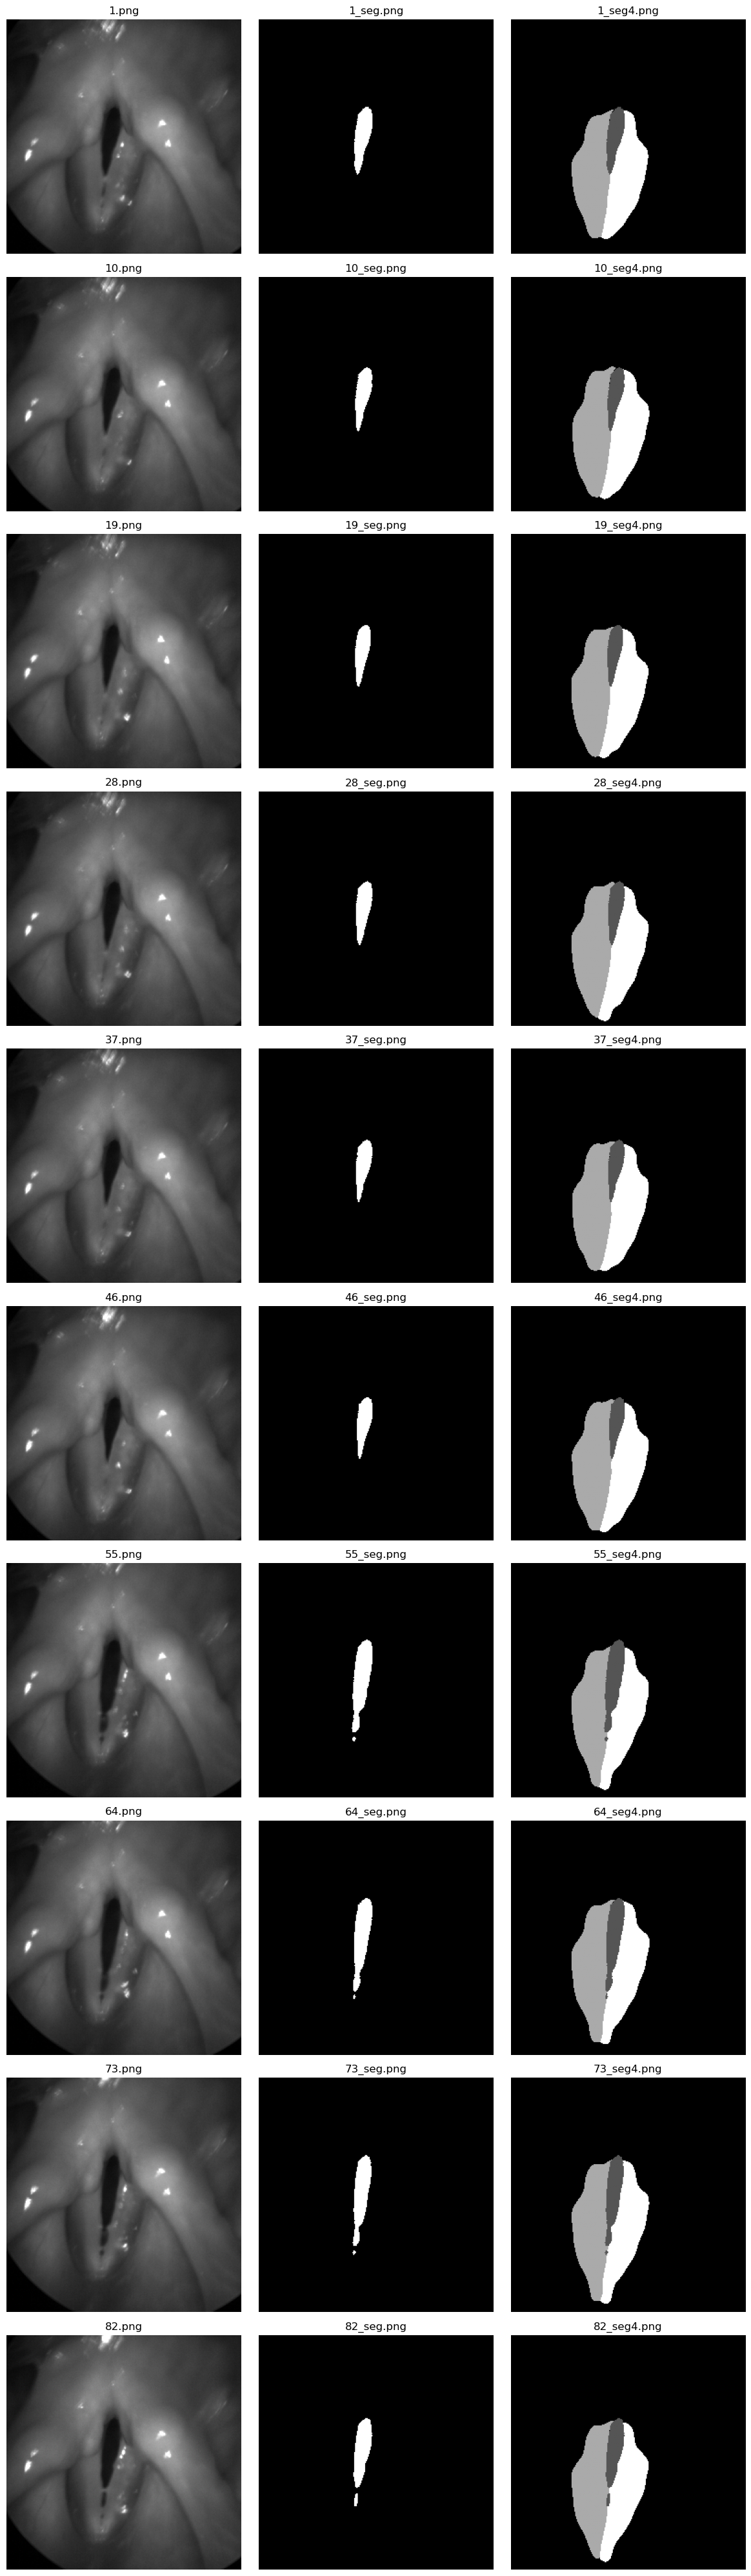

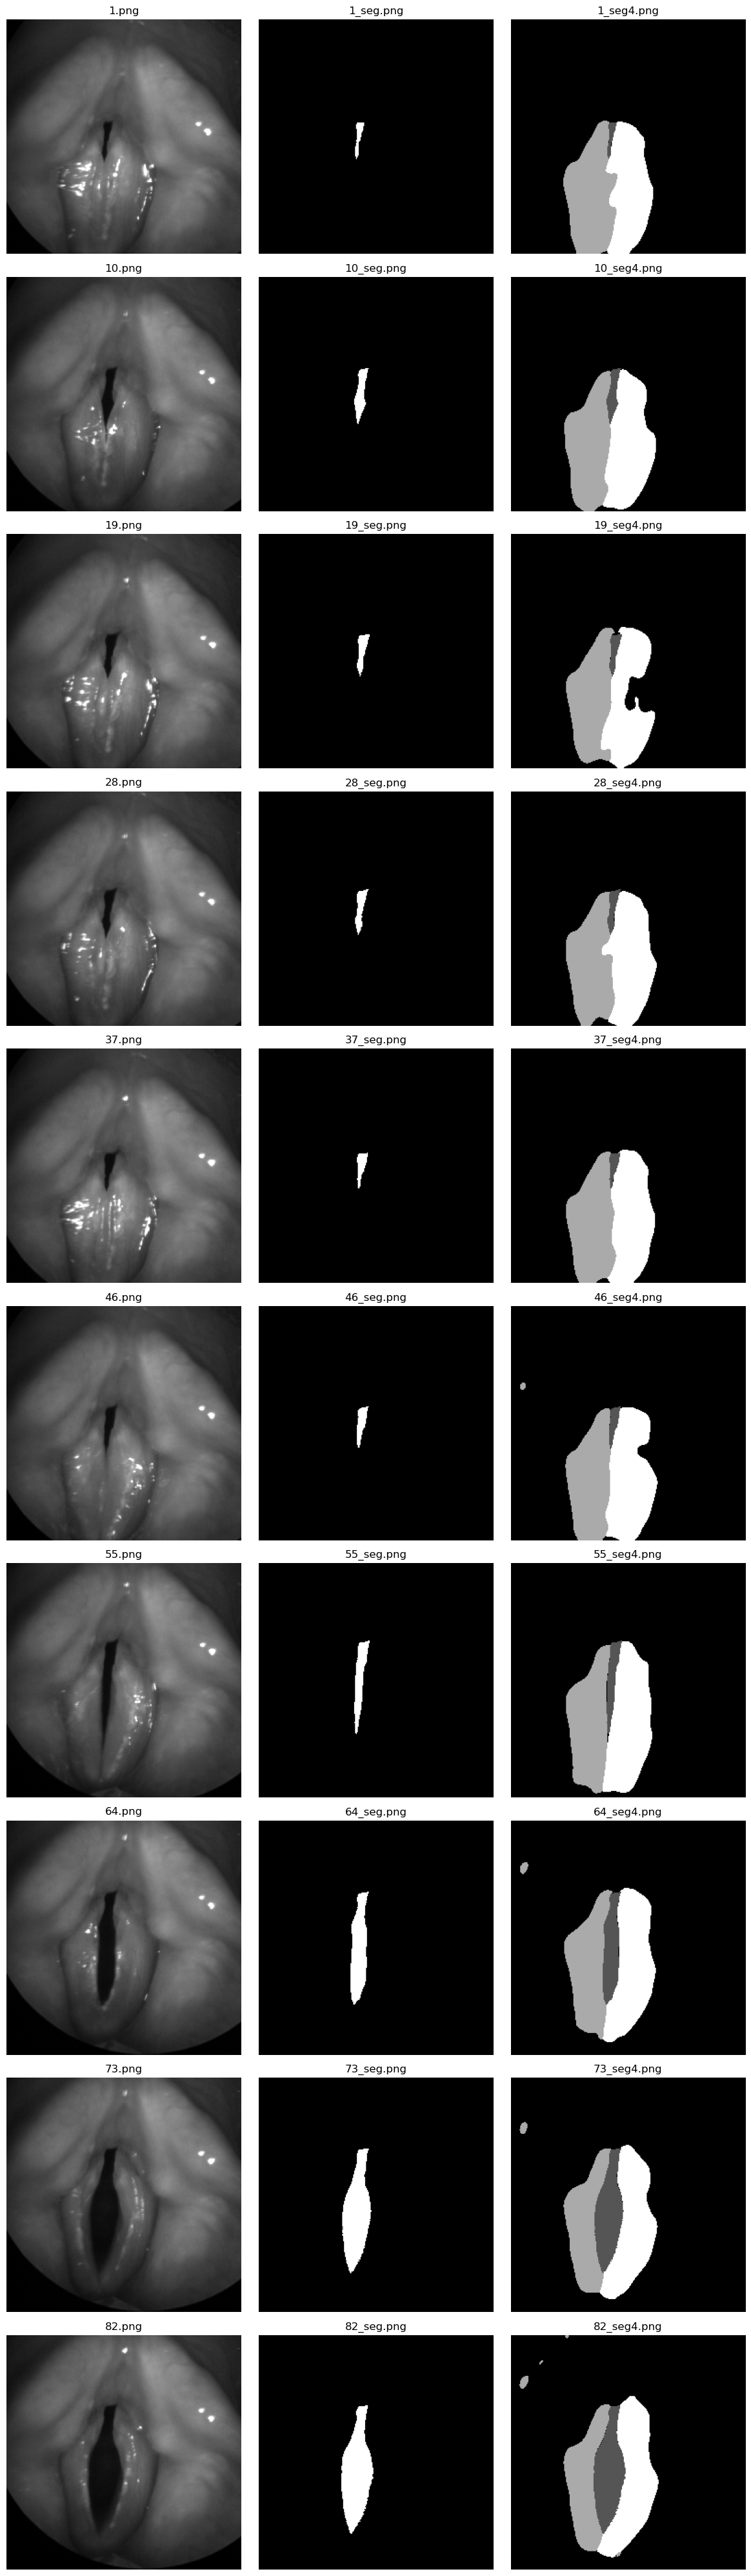

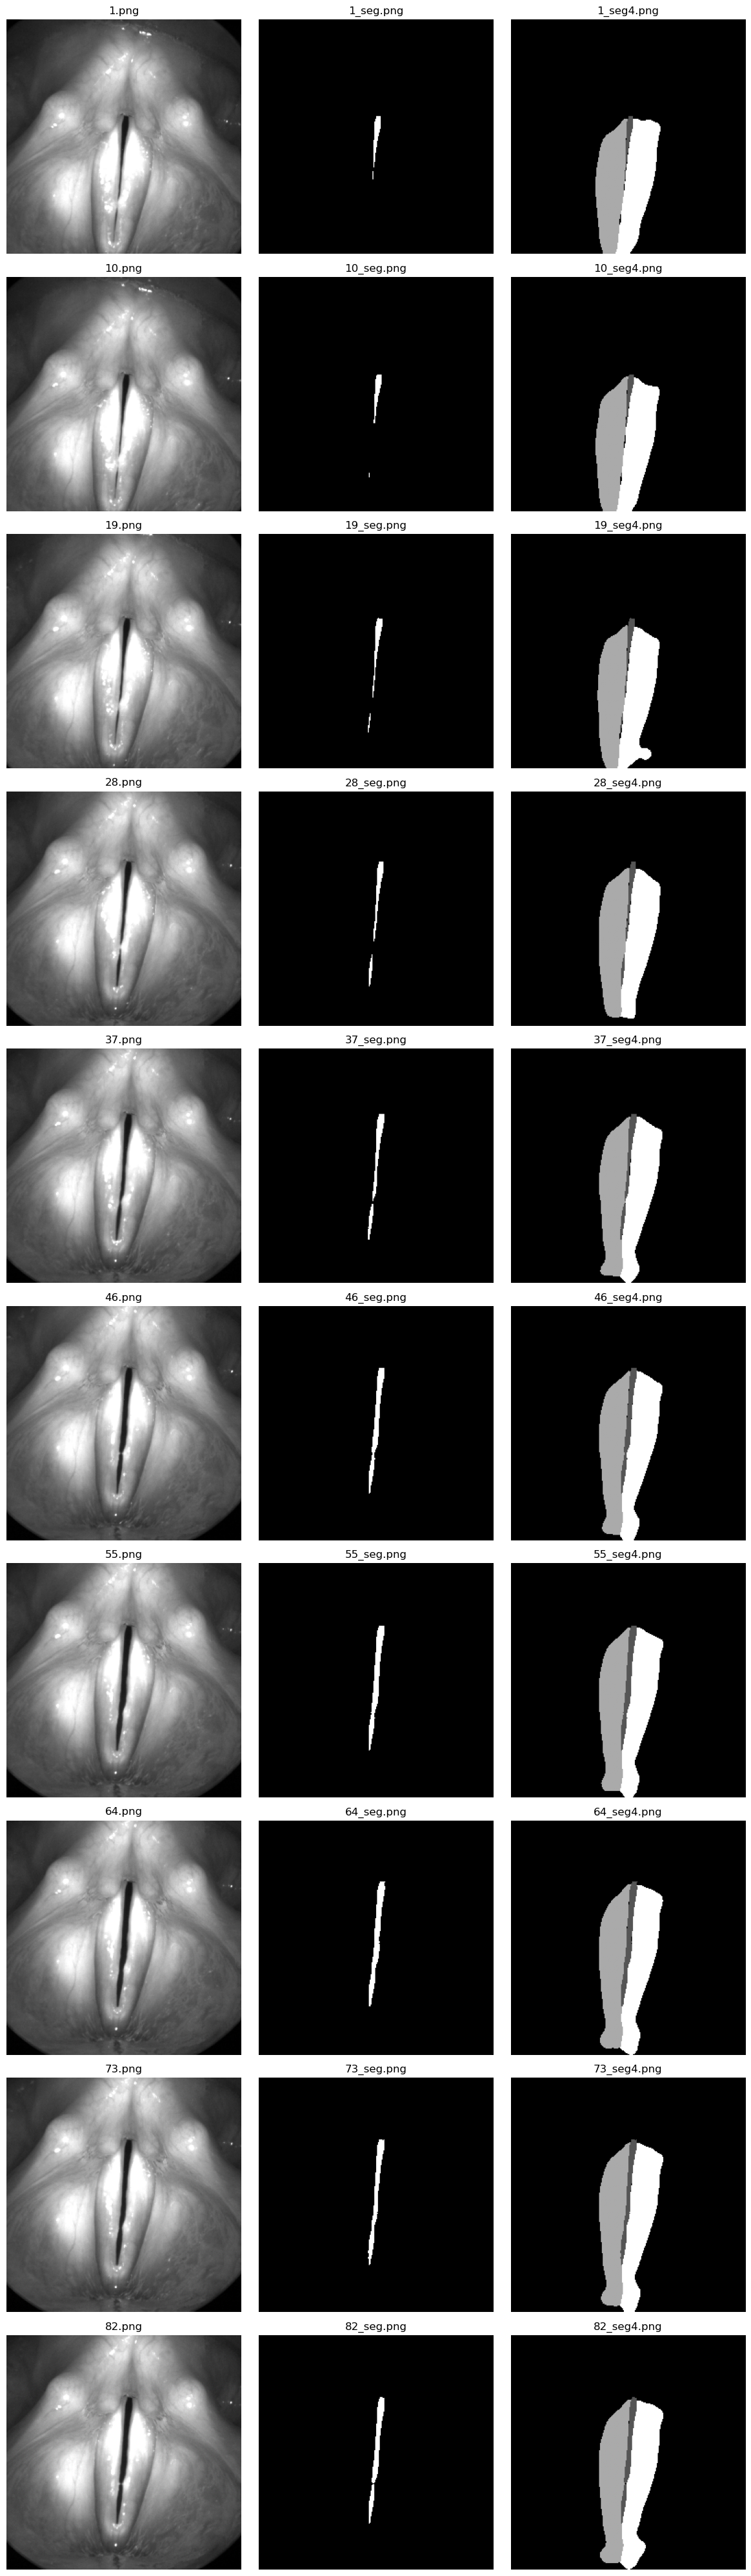

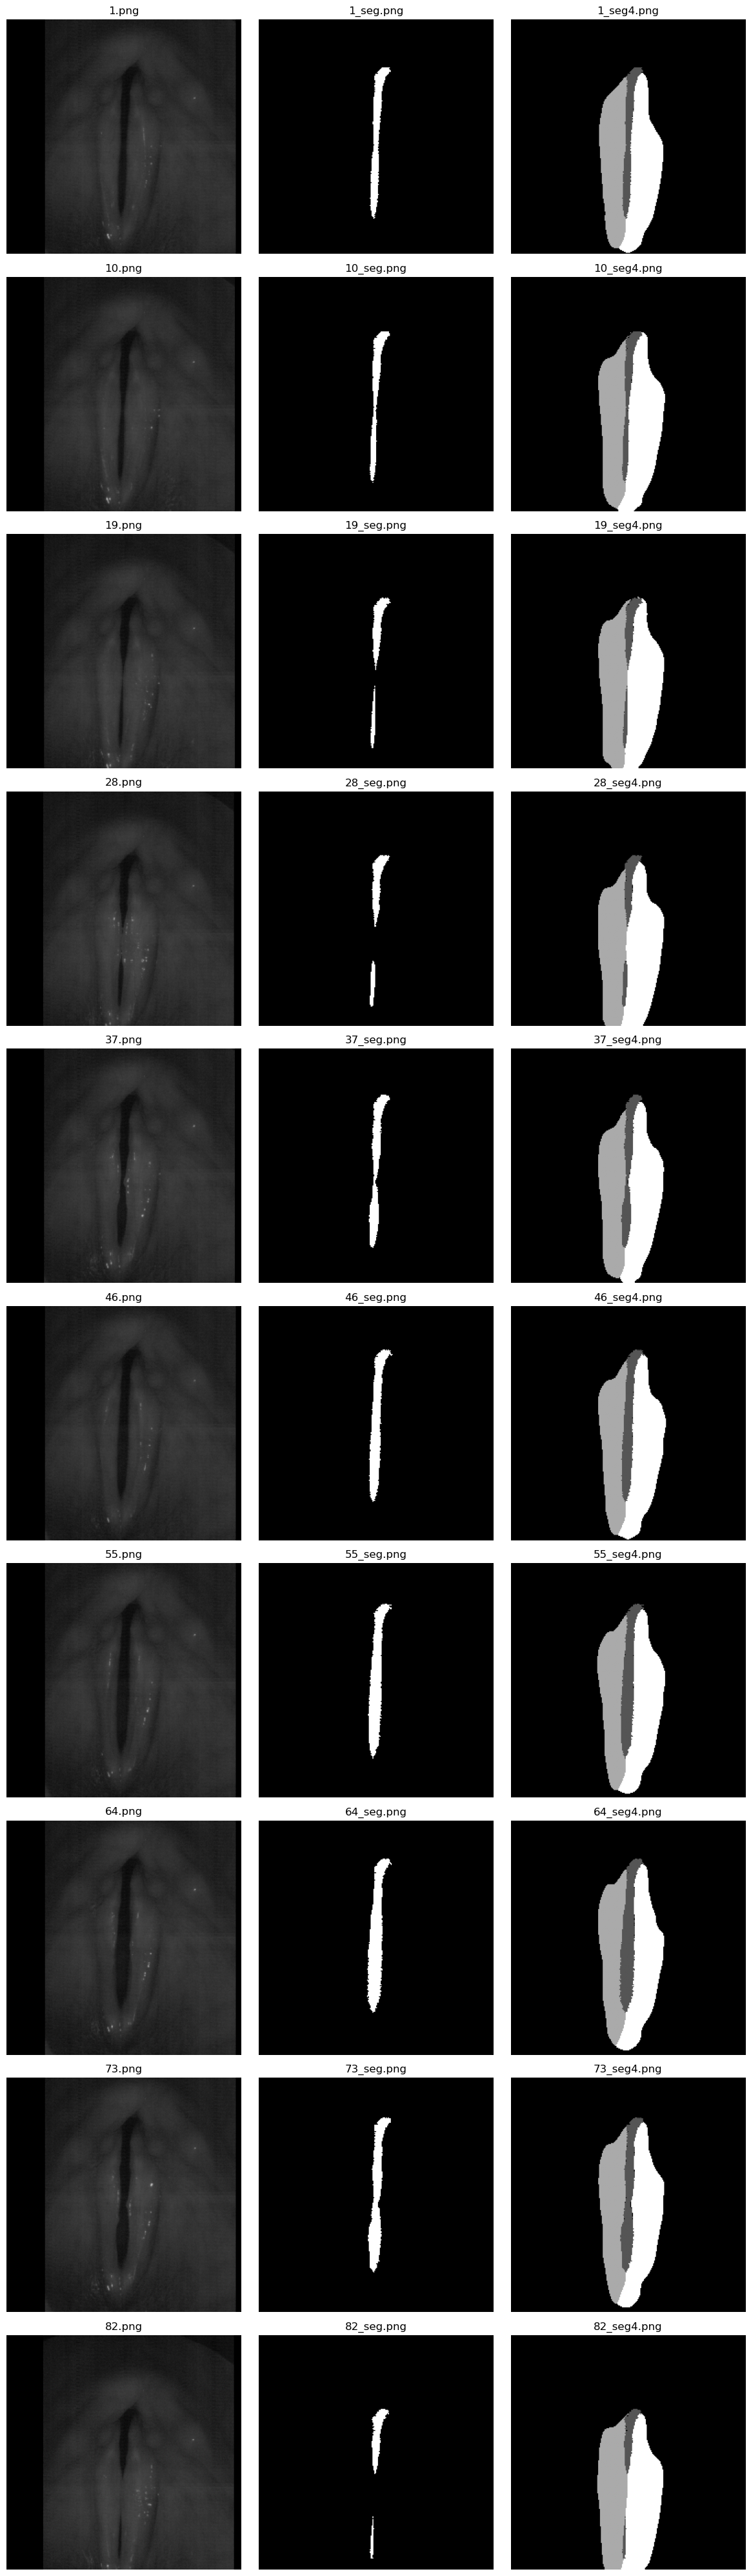

In [19]:
plot_triplets("D:/bagls-data/BAGLS/training/organized/test/512x256 - 612/croped_256")
plot_triplets(r"D:\bagls-data\BAGLS\training\organized\test\512x256 - 601\croped_256")
plot_triplets(r"D:\bagls-data\BAGLS\training\organized\test\512x352 - 93\croped_256")
plot_triplets(r"D:\bagls-data\BAGLS\training\organized\test\352x208 - 559\croped_256")

#Some examples of progressing improvement of segmentation quality for vocal folds in BAGLS dataset.

In [11]:
print("Evaluation TOP 3 SWA for DS-2. CHECK - 2")
# ============================== EVALUATE ==============================
PRED_DIR = "NN_P_Landmarks/U-LSTM5^CE_DS-2"
save_all_nn_masks_from_sequences(model, test_pairs, PRED_DIR)
save_all_nn_landmarks_from_saved_masks(PRED_DIR, "data/test/coord")
evaluate_with_top_flop(PRED_DIR, PRED_DIR)

Evaluation TOP 3 SWA for DS-2. CHECK - 2
📁 Saving prediction masks to: NN_P_Landmarks/U-LSTM5^CE_DS-2


🧭 Landmark extraction from masks: 100%|██████████████████████████████████████████| 1500/1500 [00:07<00:00, 194.56it/s]



📊 Per-Class Dice Score:
  Class 0: Dice = 0.9953 ± 0.0026
  Class 1: Dice = 0.8683 ± 0.1003
  Class 2: Dice = 0.9198 ± 0.0249
  Class 3: Dice = 0.9142 ± 0.0286

📏 Landmark P-Distances:
  D1 P1 (dorsal)    :   1.83 ±   2.84 px
  D2 P2 (ventral)   :   6.23 ±  10.51 px
  D3 P3 (right fold):   1.50 ±   2.21 px
  D4 P4 (left fold) :   1.84 ±   4.03 px

🧠 Top & Flop Predictions per 100-frame Sequence:

Sequence 1:
Top 5 samples with best DC123:
  00004 (DC123 = 0.9228)
  00005 (DC123 = 0.9220)
  00016 (DC123 = 0.9215)
  00003 (DC123 = 0.9167)
  00020 (DC123 = 0.9163)
Flop 5 samples with worst DC123:
  00072 (DC123 = 0.8449)
  00074 (DC123 = 0.8422)
  00043 (DC123 = 0.8415)
  00063 (DC123 = 0.8295)
  00059 (DC123 = 0.8182)

Sequence 2:
Top 5 samples with best DC123:
  00103 (DC123 = 0.8770)
  00124 (DC123 = 0.8759)
  00106 (DC123 = 0.8739)
  00123 (DC123 = 0.8717)
  00126 (DC123 = 0.8714)
Flop 5 samples with worst DC123:
  00110 (DC123 = 0.7513)
  00166 (DC123 = 0.7451)
  00147 (DC123 = 0.74